오늘은 트랜스포머를 이용한 챗봇을 만들어보았습니다.


# step 1. 데이터 수집하기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print("슝=3")

슝=3


In [2]:
file_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/'

chatbot_data_path = os.path.join(file_path, 'ChatbotData .csv')
print("슝=3")

!ls -l ~/aiffel/transformer_chatbot/data/

슝=3
total 1740
-rw-r--r-- 1 root root 889842 Feb 20 10:40 'ChatbotData .csv'
-rw-r--r-- 1 root root  88938 Feb 20 10:34  KETI_Office_Conversation_dataset.csv
-rw-r--r-- 1 root root 795159 Feb 20 10:34  Wellness_Conversation_dataset.csv


# step 2. 데이터 전처리하기

- 영어가 아니라 한국어 전처리는 해주지않았는데 어케할지 생각

In [3]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [4]:
import pandas as pd
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations(file_path):
    inputs, outputs = [],[]
    
    df = pd.read_csv(file_path)
    
    df_input = df['Q']
    df_output = df['A']
    
    for idx in range(len(df)):
        inputs.append(preprocess_sentence(df_input[idx]))
        outputs.append(preprocess_sentence(df_output[idx]))
        
    return inputs, outputs
        
#   id2line = {}

In [5]:
questions, answers = load_conversations(chatbot_data_path)

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


# Step 3. SubwordTextEncoder 사용하기


In [6]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

슝=3 


In [7]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [8]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]
8175


In [9]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


In [10]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5763, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


In [11]:
MAX_LENGTH = 40

In [12]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [13]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [14]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


# Step 4. 모델 구성하기


In [15]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [16]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3
슝=3


In [17]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3
슝=3


In [18]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [20]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [21]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3
슝=3


In [22]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3147008     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

# Step 5. 모델 평가하기


In [23]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [24]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

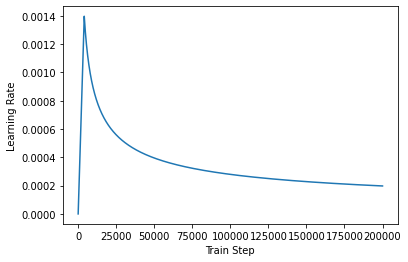

In [25]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [26]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [27]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 16s 53ms/step - loss: 1.4521 - accuracy: 0.0201
Epoch 2/20
185/185 [==============================] - 10s 53ms/step - loss: 1.1793 - accuracy: 0.0483
Epoch 3/20
185/185 [==============================] - 10s 54ms/step - loss: 1.0041 - accuracy: 0.0507
Epoch 4/20
185/185 [==============================] - 10s 54ms/step - loss: 0.9267 - accuracy: 0.0545
Epoch 5/20
185/185 [==============================] - 10s 54ms/step - loss: 0.8696 - accuracy: 0.0576
Epoch 6/20
185/185 [==============================] - 10s 54ms/step - loss: 0.8111 - accuracy: 0.0618
Epoch 7/20
185/185 [==============================] - 10s 53ms/step - loss: 0.7462 - accuracy: 0.0676
Epoch 8/20
185/185 [==============================] - 10s 53ms/step - loss: 0.6737 - accuracy: 0.0755
Epoch 9/20
185/185 [==============================] - 10s 53ms/step - loss: 0.5956 - accuracy: 0.0836
Epoch 10/20
185/185 [==============================] - 10s 53ms/step - loss: 0.512

# 모델 저장하는 부분을 추가했습니다.


In [28]:
# model.save(format='h5')

In [29]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [30]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [31]:
sentence_generation('드라마 너무 재밌더라')

입력 : 드라마 너무 재밌더라
출력 : 재미있는 다른걸 찾아보세요 .


'재미있는 다른걸 찾아보세요 .'

In [32]:
sentence_generation("나 걔 좋아해")

입력 : 나 걔 좋아해
출력 : 다른 날이 있죠 .


'다른 날이 있죠 .'

In [33]:
sentence_generation("어이없네")

입력 : 어이없네
출력 : 그냥 잊어버리세요 .


'그냥 잊어버리세요 .'

In [34]:
sentence_generation("꾸졌네")

입력 : 꾸졌네
출력 : 직접 물어보세요 .


'직접 물어보세요 .'

In [35]:
sentence_generation("어떡하지 우울해 슬퍼")

입력 : 어떡하지 우울해 슬퍼
출력 : 진짜 나빴네요 .


'진짜 나빴네요 .'

In [36]:
sentence_generation("그래서 있지, 오늘 너무 기쁘고 행복했어")

입력 : 그래서 있지, 오늘 너무 기쁘고 행복했어
출력 : 항상 아쉽지요 .


'항상 아쉽지요 .'

In [37]:
sentence_generation("좋은 아침")

입력 : 좋은 아침
출력 : 좋은 아침이에요 .


'좋은 아침이에요 .'

In [38]:
sentence_generation("잘 지내?")

입력 : 잘 지내?
출력 : 잘 지내고 있어요 .


'잘 지내고 있어요 .'

In [39]:
sentence_generation("진짜 걔 너무 싫지")

입력 : 진짜 걔 너무 싫지
출력 : 그런 생각을 해보세요 .


'그런 생각을 해보세요 .'

수정

- 전처리
- 6층 레이어
- 더 데이터

# 챗봇 개선사항 1. 더 많은 데이터 넣기

10000개의 데이터는 너무 적다는 생각이 들어서 더 많은 데이터를 넣기 위해 AI Hub, korQuad, 구글링 등 사용할 수 있는 데이터를 찾아보았습니다. 검색 시간과 깨진 데이터의 복구를 하며 몇시간을 보냈는데 유의미한 데이터를 찾지못하였습니다. 절망하고 있자 강민영(천사)님이 데이터를 던져주시고 가셨습니다. 감사인사를 드립니다..
♥from 미뇽미뇽 광팬♥

In [40]:
file_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/'

wellness_data_path = os.path.join(file_path, 'KETI_Office_Conversation_dataset.csv')
office_data_path = os.path.join(file_path, 'Wellness_Conversation_dataset.csv')
chatbot_data_path = os.path.join(file_path, 'ChatbotData .csv')

file_paths=[wellness_data_path, office_data_path, chatbot_data_path]

# 챗봇 개선사항 2. 한국어 전처리하기

- https://ebbnflow.tistory.com/246

위의 링크를 참고하여서 한국어 전처리를 더 진행해 주었습니다.

다음은 쓸데없는 문자와 특수문자등을 제거해주었습니다. 

In [41]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_punc(text_lists, punct, mapping):
    result_list = []
    
    for text in text_lists:
        
        for p in mapping: 
            text = text.replace(p, mapping[p])
            
        for p in punct: 
            text = text.replace(p, f' {p} ')
            
        specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
        for s in specials: 
            text = text.replace(s, specials[s])
            
        result_list.append(text.strip())
#         print(text.strip())
    return result_list



# PyKoSpacing 시도

> pip install git+https://github.com/haven-jeon/PyKoSpacing.git

다음과 같은 오류 발생
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires grpcio<2.0,>=1.37.0, but you have grpcio 1.34.1 which is incompatible.
tensorflow-gpu 2.6.0 requires tensorflow-estimator~=2.6, but you have tensorflow-estimator 2.5.0 which is incompatible.
grpcio-status 1.42.0 requires grpcio>=1.42.0, but you have grpcio 1.34.1 which is incompatible.
black 21.12b0 requires typing-extensions>=3.10.0.0, but you have typing-extensions 3.7.4.3 which is incompatible.

패키지들의 버전 오류가 난것이므로, 먼저 pip install grpcio==1.37.0 을 이용하여 설치를 시도했고, 다음과 같은 오류가 나타났습니다.
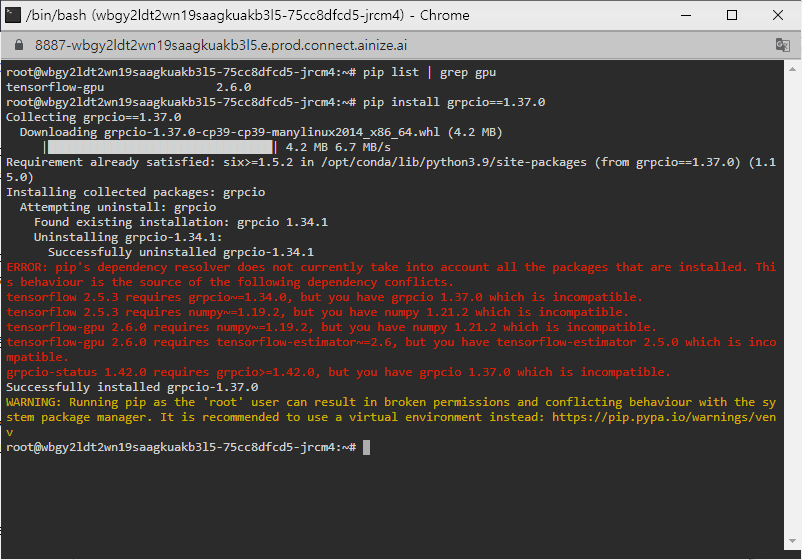

tensorflow버전까지 충돌이 일어나는데, 클라우드 환경을 바꾸기엔 너무 무서워서 일단 여기서 그만뒀습니다.

## 재시도 해서 성공

py-hanspell 패키지설치 방법에서, git clone한후, python setup.py install 하는 방법으로 다음과 같이 설치가 성공했습니다.
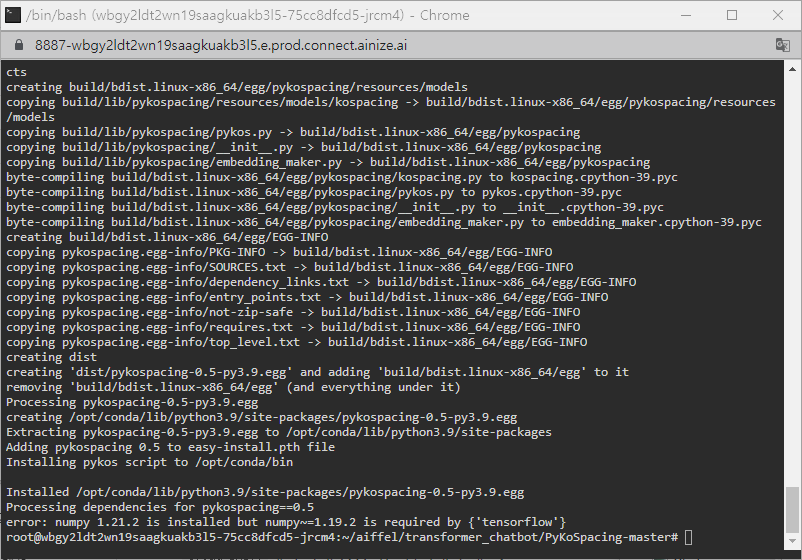


## 아니어따.

성공한줄 알았는데 Error : numpy 1.21.4 is installed but numpy~=1.19.2 is required by {'tensorflow'}가 떴습니다.
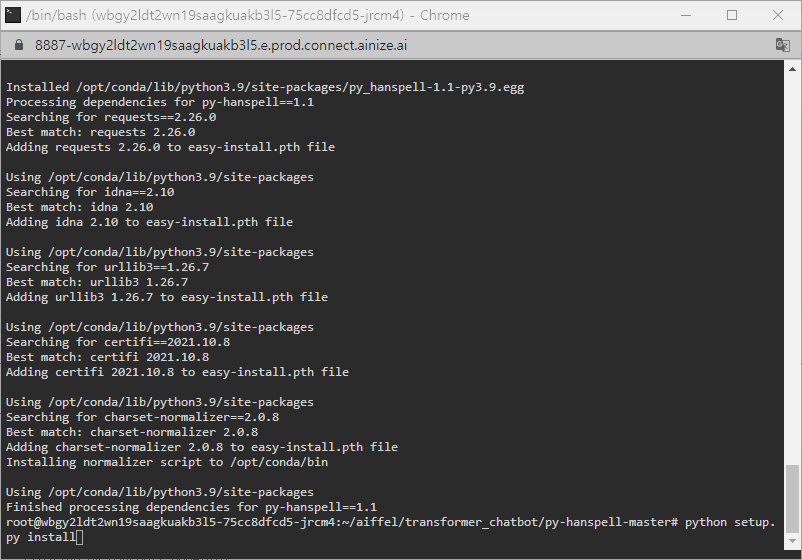

그래서 pip install numpy==1.19.2 로 강등해보았습니다.

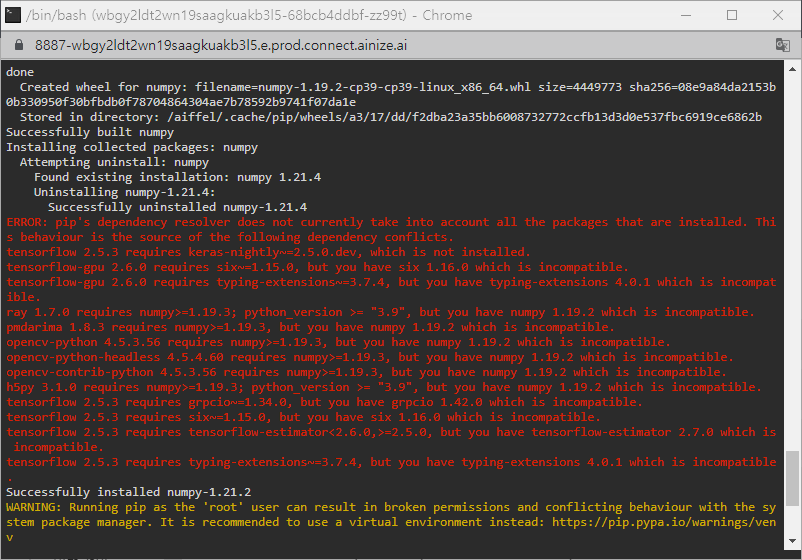

포기했습니당 ^_^

In [84]:
# from PyKoSpacing_master.pykospacing import kospacing

# def spacing(text_list):
#     result_list = []
    
#     for text in text_list:
#         # 띄어쓰기 전부 제거
#         text.repalce(" ", "")
#         result = kospacing(text)
#         result_list.append(result)
    
#     return result_list

# 한글 맞춤법 검사 라이브러리

> pip install py-hanspell

다음과 같은 오류발생

root@wbgy2ldt2wn19saagkuakb3l5-75cc8dfcd5-jrcm4:~# pip install py-hanspell
Collecting py-hanspell
  Using cached py-hanspell-1.1.tar.gz (3.0 kB)
  Preparing metadata (setup.py) ... error
  ERROR: Command errored out with exit status 1:
   command: /opt/conda/bin/python3.9 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-0z4p9o1n/py-hanspell_c6d698d9c49c44018f76b33304943cc6/setup.py'"'"'; __file__='"'"'/tmp/pip-install-0z4p9o1n/py-hanspell_c6d698d9c49c44018f76b33304943cc6/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-kx0nyf33
       cwd: /tmp/pip-install-0z4p9o1n/py-hanspell_c6d698d9c49c44018f76b33304943cc6/
  Complete output (5 lines):
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/tmp/pip-install-0z4p9o1n/py-hanspell_c6d698d9c49c44018f76b33304943cc6/setup.py", line 2, in <module>
      from pip.req import parse_requirements
  ModuleNotFoundError: No module named 'pip.req'
  ----------------------------------------
WARNING: Discarding https://files.pythonhosted.org/packages/24/81/baac88868b58eea5b0aab675da7ef0cdd72bee62b080cd50336a76faf57f/py-hanspell-1.1.tar.gz#sha256=e44953f3defb058eabe2e6b4e83a6219c3501de18385ee8c5bfa064b63005e05 (from https://pypi.org/simple/py-hanspell/). Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.
  Using cached py-hanspell-1.0.tar.gz (3.0 kB)
  Preparing metadata (setup.py) ... error
  ERROR: Command errored out with exit status 1:
   command: /opt/conda/bin/python3.9 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-0z4p9o1n/py-hanspell_126aa6aceb354476881a17a31fc95d05/setup.py'"'"'; __file__='"'"'/tmp/pip-install-0z4p9o1n/py-hanspell_126aa6aceb354476881a17a31fc95d05/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-8dhq2lh3
       cwd: /tmp/pip-install-0z4p9o1n/py-hanspell_126aa6aceb354476881a17a31fc95d05/
  Complete output (5 lines):
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/tmp/pip-install-0z4p9o1n/py-hanspell_126aa6aceb354476881a17a31fc95d05/setup.py", line 2, in <module>
      from pip.req import parse_requirements
  ModuleNotFoundError: No module named 'pip.req'
  ----------------------------------------
WARNING: Discarding https://files.pythonhosted.org/packages/be/4d/bf6a3b891f30fceacce5a83a987a294317ec41ab899b4b5a2b404a0f88d5/py-hanspell-1.0.tar.gz#sha256=e1468423c130f4fbc99de1909dc0509412792ec19c3fbed949f9778170161cf5 (from https://pypi.org/simple/py-hanspell/). Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.
ERROR: Could not find a version that satisfies the requirement py-hanspell (from versions: 1.0, 1.1)
ERROR: No matching distribution found for py-hanspell

stackoverflow에서 다른 패키지지만 동일한 오류를 발견했습니다.

    - https://stackoverflow.com/questions/25192794/no-module-named-pip-req

- 해당 링크를 보니 setup.py의 수정이 필요하여 다음 링크에서 패키지를 다운하고, 직접 다운했습니다.    https://github.com/ssut/py-hanspell
    
    
- 시도를 하다가, git 깃허브를 클론한 후, 해당 디렉토리에서 python setup.py install 하는 방법을 발견해 시도하였고, 설치가 성공했습니다.
    
    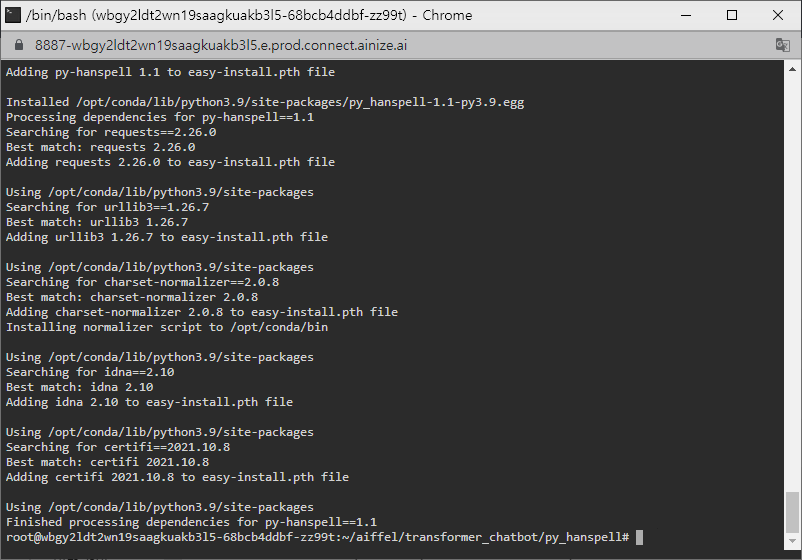

In [43]:
from py_hanspell.hanspell import spell_checker

## 실제 전처리하는 부분

### 기존의 preprocess

In [44]:
import pandas as pd
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations(file_path):
    inputs, outputs = [],[]
    
    for idx in range(len(file_path)):
        print(file_path[idx])
        df = pd.read_csv(file_path[idx])

        df_input = df['Q']
        df_output = df['A']

        for idx in range(len(df)):
            inputs.append(preprocess_sentence(df_input[idx]))
            outputs.append(preprocess_sentence(df_output[idx]))

    return inputs, outputs
        
#   id2line = {}

In [45]:
questions, answers = load_conversations(file_paths)

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

# print(questions[12000:13000])


/aiffel/aiffel/transformer_chatbot/data/KETI_Office_Conversation_dataset.csv
/aiffel/aiffel/transformer_chatbot/data/Wellness_Conversation_dataset.csv
/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv
전체 샘플 수 : 18379
전체 샘플 수 : 18379


### clean_punc 메소드

In [46]:
questions = clean_punc(questions, punct, punct_mapping)
answers = clean_punc(questions, punct, punct_mapping)

# print(questions[:5000])
# print("end")
# questions = clean_text(questions)

# print(questions[:500])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 18379
전체 샘플 수 : 18379


### spell_checker

In [47]:

def spell_checking(text_lists):
    try:
        result_list = []
        for idx, text in enumerate(text_lists):
            result = spell_checker.check(text) 
            result =  ' '.join(result.split())
            result_list.append(result.as_dict().get('checked'))  # dict로 출력
            if(idx%2500==0):
                print(idx)
        return result_list
    except :
        print("error 발생 index", idx)
        print("error 발생전 Question", questions[idx-1])
        print("error 발생전 Answer", answers[idx-1])
        print("error 발생 Question", questions[idx])
        print("error 발생 Answer", answers[idx])
        print("error 발생후 Question", questions[idx+1])
        print("error 발생후 Answer", answers[idx+1])
        pass

spell_checking(questions[:])
print("end Questions")
spell_checking(answers[:])
print("end Answers")

error 발생 index 0
error 발생전 Question 힘들어서 결혼할까봐
error 발생전 Answer 힘들어서 결혼할까봐
error 발생 Question 좋은 아침  .
error 발생 Answer 좋은 아침   .
error 발생후 Question 좋은 아침  .
error 발생후 Answer 좋은 아침   .
end Questions
error 발생 index 0
error 발생전 Question 힘들어서 결혼할까봐
error 발생전 Answer 힘들어서 결혼할까봐
error 발생 Question 좋은 아침  .
error 발생 Answer 좋은 아침   .
error 발생후 Question 좋은 아침  .
error 발생후 Answer 좋은 아침   .
end Answers


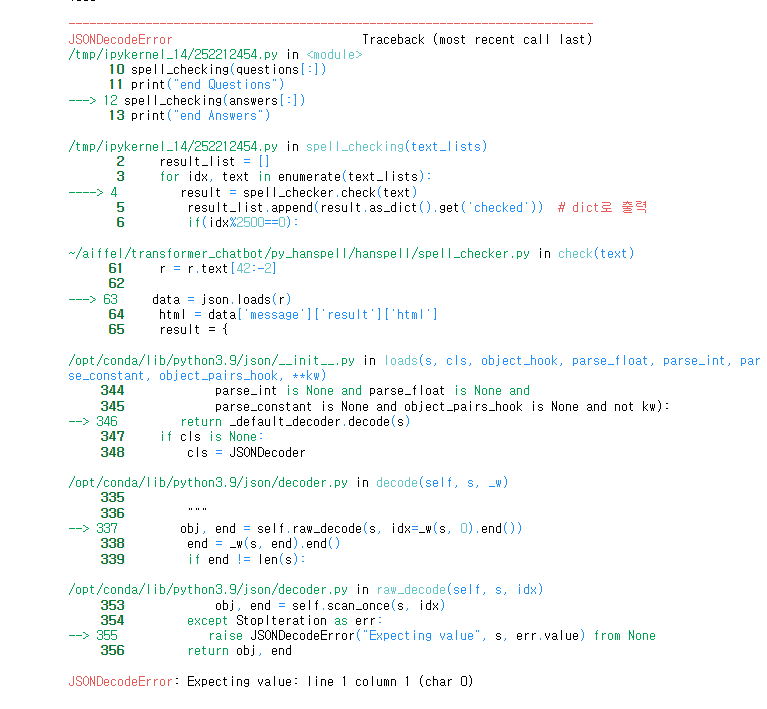

Answer에서 이런 오류가 났는데, spell_checking의 전체를 try_except 문으로 감싸주어서 해결하였습니다. (근데 왜 print되지 않았을까요..?)

In [48]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 18379
전체 샘플 수 : 18379


# step3 SubwordTextEncoder 사용하기

In [49]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [50]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [7799]
END_TOKEN의 번호 : [7800]
7801


In [51]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 안녕 컴패니언  .
전처리 후의 22번째 답변 샘플: 안녕 컴패니언   .


In [52]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [2919, 881, 1]
정수 인코딩 후의 21번째 답변 샘플: [2919, 881, 2]


In [53]:
MAX_LENGTH = 40

In [54]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [55]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 7801
필터링 후의 질문 샘플 개수: 18378
필터링 후의 답변 샘플 개수: 18378


In [56]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


# step 4 모델 구성하기

In [57]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [58]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3
슝=3


In [59]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3
슝=3


In [60]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


In [61]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [62]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [63]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3
슝=3


# 챗봇 개선사항 3. 레이어 수 늘려주기

논문에서는 6층의 레이어가 있었기 때문에, 저도 6층으로 늘려보았습니다.

In [64]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    16610816    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

# step 5. 모델 평가하기

In [65]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [66]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

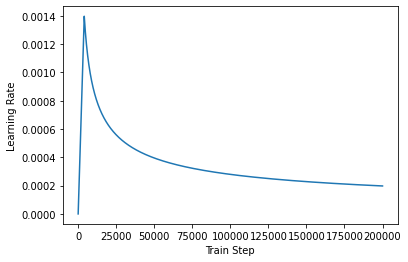

In [67]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [68]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


기존에 epoch 20에서 accuracy가 너무 낮아서 대폭 올려보았습니다.


In [69]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
288/288 [==============================] - 87s 249ms/step - loss: 1.6172 - accuracy: 0.0277
Epoch 2/100
288/288 [==============================] - 71s 248ms/step - loss: 1.3439 - accuracy: 0.0469
Epoch 3/100
288/288 [==============================] - 71s 248ms/step - loss: 1.2189 - accuracy: 0.0581
Epoch 4/100
288/288 [==============================] - 72s 248ms/step - loss: 1.1098 - accuracy: 0.0655
Epoch 5/100
288/288 [==============================] - 72s 249ms/step - loss: 1.0025 - accuracy: 0.0724
Epoch 6/100
288/288 [==============================] - 72s 248ms/step - loss: 0.8881 - accuracy: 0.0805
Epoch 7/100
288/288 [==============================] - 71s 248ms/step - loss: 0.7850 - accuracy: 0.0870
Epoch 8/100
288/288 [==============================] - 72s 248ms/step - loss: 0.6919 - accuracy: 0.0931
Epoch 9/100
288/288 [==============================] - 71s 248ms/step - loss: 0.6082 - accuracy: 0.0988
Epoch 10/100
288/288 [==============================] - 71s 247m

288/288 [==============================] - 71s 247ms/step - loss: 0.0177 - accuracy: 0.2049
Epoch 80/100
288/288 [==============================] - 71s 247ms/step - loss: 0.0180 - accuracy: 0.2048
Epoch 81/100
288/288 [==============================] - 71s 247ms/step - loss: 0.0170 - accuracy: 0.2051
Epoch 82/100
288/288 [==============================] - 71s 247ms/step - loss: 0.0168 - accuracy: 0.2052
Epoch 83/100
288/288 [==============================] - 71s 247ms/step - loss: 0.0157 - accuracy: 0.2055
Epoch 84/100
288/288 [==============================] - 71s 246ms/step - loss: 0.0159 - accuracy: 0.2055
Epoch 85/100
288/288 [==============================] - 71s 246ms/step - loss: 0.0155 - accuracy: 0.2055
Epoch 86/100
288/288 [==============================] - 71s 247ms/step - loss: 0.0149 - accuracy: 0.2057
Epoch 87/100
288/288 [==============================] - 71s 247ms/step - loss: 0.0152 - accuracy: 0.2056
Epoch 88/100
288/288 [==============================] - 71s 247ms/st

In [70]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [71]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [72]:
sentence_generation('드라마 너무 재밌더라')

입력 : 드라마 너무 재밌더라
출력 : 드라마 너무 재밌네


'드라마 너무 재밌네'

In [73]:
sentence_generation("나 걔 좋아해")

입력 : 나 걔 좋아해
출력 : 나 속게


'나 속게'

In [74]:
sentence_generation("어이없네")

입력 : 어이없네
출력 : 어이없네


'어이없네'

In [75]:
sentence_generation("꾸졌네")

입력 : 꾸졌네
출력 : 힘들어서 많이 있어


'힘들어서 많이 있어'

In [76]:
sentence_generation("어떡하지 우울해 슬퍼")

입력 : 어떡하지 우울해 슬퍼
출력 : 배고파 우울해


'배고파 우울해'

In [77]:
sentence_generation("그래서 있지, 오늘 너무 기쁘고 행복했어")

입력 : 그래서 있지, 오늘 너무 기쁘고 행복했어
출력 : 오늘 이별을    .   오늘 너무 아파 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 


'오늘 이별을    .   오늘 너무 아파 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 '

In [78]:
sentence_generation("좋은 아침")

입력 : 좋은 아침
출력 : 좋은 아침


'좋은 아침'

In [79]:
sentence_generation("잘 지내?")

입력 : 잘 지내?
출력 : 잘 지내나 지내


'잘 지내나 지내'

In [80]:
sentence_generation("진짜 걔 너무 싫지")

입력 : 진짜 걔 너무 싫지
출력 : 진짜 너무 싫어


'진짜 너무 싫어'

# 회고
- 0.1646->0.2064으로 Accuracy가 소폭 올랐다. Accuracy를 더 높일 수 있는 방법은 무엇이 있을까? 
- accuracy가 낮다고 무작정 파라미터수를 늘리고 Epoch를 높이는게 정확도를 높이는 좋은 수단은 아닌것 같다.
- 양질의 데이터는 어디서 얻을 수 있을까?
- 대답이 자연스러운것도 있고 이상하거나 반복되는 것도 있다. 일단, 데이터 내의 어휘가 한계가 있기에 다양한 문장 형성이 어려운것같다.
- 더 좋은 성능을 가진 챗봇은,, 데이터에 달렷을까 모델에 달렷을까?

# 다음에 더 연구해볼 것

- PyKoSpacing 적용해보기.
PyKoSpacing은 모든 문자열에서 띄어쓰기를 제거한 후, 맞춤법에 맞게 띄어쓰기를 적용해주는 패키지입니다. 여러 출처에 있는 데이터를 가져와 학습시킬 경우, 띄어쓰기가 무질서하게되어있어 토큰화에 어려움이 많을거라 생각했습니다. 넓은 범위로 퍼진 데이터를 정규화해주듯, NLP에서 정규화해주는 (데이터를 통일시켜주는) 과정이 띄어쓰기등을 통일화시켜주는거라고 생각해서 꼭 써보고싶었는데 패키지 설치가 실패해서 아쉽습니다.
conda에서는 여러버전의 파이선 패키지를 사용해야 할 경우 conda create env 명령어를 이용해서 가상의 컨테이너를 만들수있는걸로 압니다. 이걸 사용해서 꼭 다음엔 전처리를 잘 마무리하고싶습니다.

- Tokenizer, 전처리 각 단계마다의 Questions, Answers CSV로 뽑아보기
오늘 이별을    .   오늘 너무 아파 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 오늘 ' 과 같은 결과가 나온것을 보면, 오늘 뒤에 오늘이 오는경우가 많은것 같다. 학습 중에 토큰화가 어떻게 되는지, questions와 answers가 어떻게  바뀌는지 중간과정을 확인해야겠다고 생각했습니다.

- 아래 두개의 전처리 부분도 해보기

In [81]:
import re 
def clean_text(texts): 
    corpus = [] 
    for i in range(0, len(texts)): 
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i]))
        #remove punctuation 
        review = re.sub(r'\d+','', str(texts[i]))# remove number 
        review = review.lower() #lower case 
        review = re.sub(r'\s+', ' ', review) #remove extra space 
        review = re.sub(r'<[^>]+>','',review) #remove Html tags 
        review = re.sub(r'\s+', ' ', review) #remove spaces 
        review = re.sub(r"^\s+", '', review) #remove space from start 
        review = re.sub(r'\s+$', '', review) #remove space from the end 
    corpus.append(review) 
    return corpus



In [82]:
!pip install soynlp

In [83]:
from soynlp.normalizer import * 
# print(repeat_normalize('와하하하하하하하하하핫', num_repeats=2))

for idx in range(len(questions)):
    answers[idx] = repeat_normalize(answers[idx], num_repeats=2)
    questions[idx] = repeat_normalize(questions[idx], num_repeats=2)

TypeError: cannot use a string pattern on a bytes-like object